In [128]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime
from math import floor
from termcolor import colored as cl 


from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

## Generate Dataset
---

In [129]:
# set ticker
ticker = "MSFT"

# set timeframe for data
start = '2020-01-01'
end = '2021-01-01'

# pull historical stock data from 1/10/2005 to 3/8/2021
yf.pdr_override()
stock_data = pdr.get_data_yahoo(ticker, start=start, end=end)

ticker_data = pdr.get_data_yahoo(ticker, start=start, end=end)

# Dropping the dividends and stock split columns
trading_signals = ticker_data.drop(columns=['Open', 'High', 'Low','Volume','Adj Close'])
trading_signals.head()

# drop Dividends and Stock Split columns
stock_data = stock_data.drop(columns=['Adj Close'])
stock_data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,158.779999,160.729996,158.330002,160.619995,22622100
2020-01-03,158.320007,159.949997,158.059998,158.619995,21116200
2020-01-06,157.080002,159.100006,156.509995,159.029999,20813700
2020-01-07,159.320007,159.669998,157.320007,157.580002,21634100
2020-01-08,158.929993,160.800003,157.949997,160.089996,27746500


### Filter the dataset

In [130]:
# Filter the date index and close columns
signals_df = stock_data.loc[:, ["Close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Add in a binary classifier for positive and negative price changes. Set threshold at +/- 0.01%
signals_df['Target'] = (
    (np.where(signals_df['Actual Returns'] > 0.01, 1.0, 0.0)) + 
    (np.where(signals_df['Actual Returns'] < -0.01, -1.0, 0.0))
)

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,Target
Date,,,
2020-01-03,158.619995,-0.012452,-1.0
2020-01-06,159.029999,0.002585,0.0
2020-01-07,157.580002,-0.009118,0.0
2020-01-08,160.089996,0.015928,1.0
2020-01-09,162.089996,0.012493,1.0


,Close,Actual Returns,Target
Date,,,
2020-12-24,222.750000,0.007827,0.0
2020-12-28,224.960007,0.009921,0.0
2020-12-29,224.149994,-0.003601,0.0
2020-12-30,221.679993,-0.011019,-1.0
2020-12-31,222.419998,0.003338,0.0


## Generate trading signals
---

### RSI

In [131]:
val_signals_df = stock_data.loc[:, ["Close"]]

short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
val_signals_df['fast_close'] = val_signals_df['Close'].ewm(halflife=short_window).mean()
val_signals_df['slow_close'] = val_signals_df['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
val_signals_df['crossover_long'] = np.where(val_signals_df['fast_close'] > val_signals_df['slow_close'], 1.0, 0.0)
val_signals_df['crossover_short'] = np.where(val_signals_df['fast_close'] < val_signals_df['slow_close'], -1.0, 0.0)
val_signals_df['crossover_signal'] = val_signals_df['crossover_long'] + val_signals_df['crossover_short']


# Generate the short and long moving averages (50 and 100 days, respectively)
val_signals_df["SMA50"] = val_signals_df["Close"].rolling(window=short_window).mean()
val_signals_df["SMA100"] = val_signals_df["Close"].rolling(window=long_window).mean()
val_signals_df["Signal"] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
val_signals_df["Signal"][short_window:] = np.where(
    val_signals_df["SMA50"][short_window:] > val_signals_df["SMA100"][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
val_signals_df["Entry/Exit"] = val_signals_df["Signal"].diff()

val_signals_df.head(10)

,Close,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,SMA50,SMA100,Signal,Entry/Exit
Date,,,,,,,,,,
2020-01-02,160.619995,160.619995,160.619995,0.0,0.0,0.0,160.619995,NaN,0.0,NaN
2020-01-03,158.619995,159.286662,159.585352,0.0,-1.0,-1.0,158.619995,NaN,0.0,0.0
2020-01-06,159.029999,159.139997,159.387265,0.0,-1.0,-1.0,159.029999,NaN,0.0,0.0
2020-01-07,157.580002,158.308000,158.887446,0.0,-1.0,-1.0,157.580002,NaN,0.0,0.0
2020-01-08,160.089996,159.227740,159.162397,1.0,0.0,1.0,160.089996,NaN,0.0,0.0
2020-01-09,162.089996,160.681584,159.738605,1.0,0.0,1.0,162.089996,NaN,0.0,0.0
2020-01-10,161.339996,161.013383,160.017566,1.0,0.0,1.0,161.339996,NaN,0.0,0.0
2020-01-13,163.279999,162.151135,160.530840,1.0,0.0,1.0,163.279999,NaN,0.0,0.0
2020-01-14,162.130005,162.140549,160.761584,1.0,0.0,1.0,162.130005,NaN,0.0,0.0


In [132]:
# Visualize exit position relative to close price
exit = val_signals_df[val_signals_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = val_signals_df[val_signals_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = val_signals_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize moving averages
moving_avgs = val_signals_df[['SMA50', 'SMA100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [170]:
#Felix's DF#
# Set the windows
short_window = 50
long_window = 100

# Generate the short (50 days) and long moving averages(100 days) 
trading_signals["SMA50"] = trading_signals["Close"].rolling(window=short_window).mean()
trading_signals["SMA100"] = trading_signals["Close"].rolling(window=long_window).mean()
trading_signals["Signal"] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
trading_signals["Signal"][short_window:] = np.where(
    trading_signals["SMA50"][short_window:] > trading_signals["SMA100"][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
trading_signals["Entry/Exit"] = trading_signals["Signal"].diff()


# Visualize exit point compared to closing price
exit = trading_signals[trading_signals['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in USD $',
    width=1100,
    height=600
)
# Visualize entry point compared to the closing price
entry = trading_signals[trading_signals['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in USD $',
    width=1100,
    height=600
)
# Visualize closing price
close_price = trading_signals[['Close']].hvplot(
    line_color='lightblue',
    ylabel='Closing Price in USD $',
    width=1100,
    height=600
)
# Visualize moving averages
mv_avgs = trading_signals[['SMA50', 'SMA100']].hvplot(
    ylabel='Closing Price in USD $',
    width=1100,
    height=600
)
# Generate the plots
entry_exit_plot = close_price * mv_avgs * entry * exit
entry_exit_plot.opts(xaxis=True)


# Calulate the Short and Long EMA
EMA_short = trading_signals.Close.ewm(span=12, adjust=False).mean()
EMA_long = trading_signals.Close.ewm(span=24, adjust=False).mean()

# Calculate the MACD
MACD = EMA_short - EMA_long

signal = MACD.ewm(span=9, adjust=False).mean()


trading_signals["MACD"] = MACD
trading_signals["Signal"] = signal
trading_signals

def entry_exit(signal):
    Entry = []
    Exit = []
    flag = -1
    
    for i in range(0, len(signal)):
        if signal["MACD"][i] > signal["Signal"][i]:
            Exit.append(np.nan)
            if flag != 1:
                Entry.append(signal["Close"][i])
                flag = 1
            else:
                Entry.append(np.nan)
        elif signal["MACD"][i] < signal["Signal"][i]:
            Entry.append(np.nan)
            if flag != 0:
                Exit.append(signal["Close"][i])
                flag = 0
            else:
                Exit.append(np.nan)
        else:
            Entry.append(np.nan)
            Exit.append(np.nan)
            
    return (Entry, Exit)

data = entry_exit(trading_signals)
trading_signals["Entry_Point"] = data[0]
trading_signals["Exit_Point"] = data[1]

trading_signals

,Close,SMA50,SMA100,Signal,Entry/Exit,MACD,Entry_Point,Exit_Point
Date,,,,,,,,
2020-01-02,160.619995,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN
2020-01-03,158.619995,NaN,NaN,-0.029538,0.0,-0.147692,NaN,158.619995
2020-01-06,159.029999,NaN,NaN,-0.069745,0.0,-0.230570,NaN,NaN
2020-01-07,157.580002,NaN,NaN,-0.135661,0.0,-0.399326,NaN,NaN
2020-01-08,160.089996,NaN,NaN,-0.176615,0.0,-0.340428,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-12-24,222.750000,214.641400,213.2489,1.237289,0.0,2.026699,NaN,NaN
2020-12-28,224.960007,214.747400,213.3691,1.449538,0.0,2.298533,NaN,NaN
2020-12-29,224.149994,214.837199,213.4471,1.644039,0.0,2.422040,NaN,NaN


RSI = 100 – [100 / ( 1 + (EMA_up / EMA_down) ) ] where,

EMAup = Exponential Moving Average of Upward Price Change

EMAdown = Exponential Moving Average of Downward Price Change

In [171]:
# Set RSI trading window
RSI_window = 20

#create new df for bollinger bands
RSI_df = signals_df.copy()

#Create function for RSI calculation
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

RSI_df [f'rsi_{RSI_window}'] = get_rsi(RSI_df['Close'], RSI_window)
RSI_df = RSI_df.dropna()
RSI_df

,Close,Actual Returns,Target,rsi_20
Date,,,,
2020-01-09,162.089996,0.012493,1.0,89.715044
2020-01-10,161.339996,-0.004627,0.0,84.473648
2020-01-13,163.279999,0.012024,1.0,86.604520
2020-01-14,162.130005,-0.007043,0.0,79.773055
2020-01-15,163.179993,0.006476,0.0,81.198440
...,...,...,...,...
2020-12-24,222.750000,0.007827,0.0,58.259551
2020-12-28,224.960007,0.009921,0.0,60.330829
2020-12-29,224.149994,-0.003601,0.0,59.197491


In [172]:
#RSI Trading Signal

upper_limit = 70
lower_limit = 30


# Calculate rolling mean and standard deviation
RSI_df['RSI_mid_band'] = RSI_df['Close'].rolling(window=RSI_window).mean()
RSI_df['RSI_std'] = RSI_df['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
RSI_df['RSI_upper_band']  = RSI_df['RSI_mid_band'] + (RSI_df['RSI_std'] * 1)
RSI_df['RSI_lower_band']  = RSI_df['RSI_mid_band'] - (RSI_df['RSI_std'] * 1)


# Calculate RSI trading signal
RSI_df['RSI_long'] = np.where(RSI_df['rsi_20'] < lower_limit, 1.0, 0.0)
RSI_df['RSI_short'] = np.where(RSI_df['Close'] > upper_limit, -1.0, 0.0)
RSI_df['RSI_signal'] = RSI_df['RSI_long'] + RSI_df['RSI_short']

    
RSI_df

,Close,Actual Returns,Target,rsi_20,RSI_mid_band,RSI_std,RSI_upper_band,RSI_lower_band,RSI_long,RSI_short,RSI_signal
Date,,,,,,,,,,,
2020-01-09,162.089996,0.012493,1.0,89.715044,NaN,NaN,NaN,NaN,0.0,-1.0,-1.0
2020-01-10,161.339996,-0.004627,0.0,84.473648,NaN,NaN,NaN,NaN,0.0,-1.0,-1.0
2020-01-13,163.279999,0.012024,1.0,86.604520,NaN,NaN,NaN,NaN,0.0,-1.0,-1.0
2020-01-14,162.130005,-0.007043,0.0,79.773055,NaN,NaN,NaN,NaN,0.0,-1.0,-1.0
2020-01-15,163.179993,0.006476,0.0,81.198440,NaN,NaN,NaN,NaN,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,222.750000,0.007827,0.0,58.259551,216.564000,3.807338,220.371338,212.756662,0.0,-1.0,-1.0
2020-12-28,224.960007,0.009921,0.0,60.330829,217.050500,4.226485,221.276985,212.824016,0.0,-1.0,-1.0
2020-12-29,224.149994,-0.003601,0.0,59.197491,217.554500,4.447586,222.002086,213.106913,0.0,-1.0,-1.0


<AxesSubplot:xlabel='Date'>

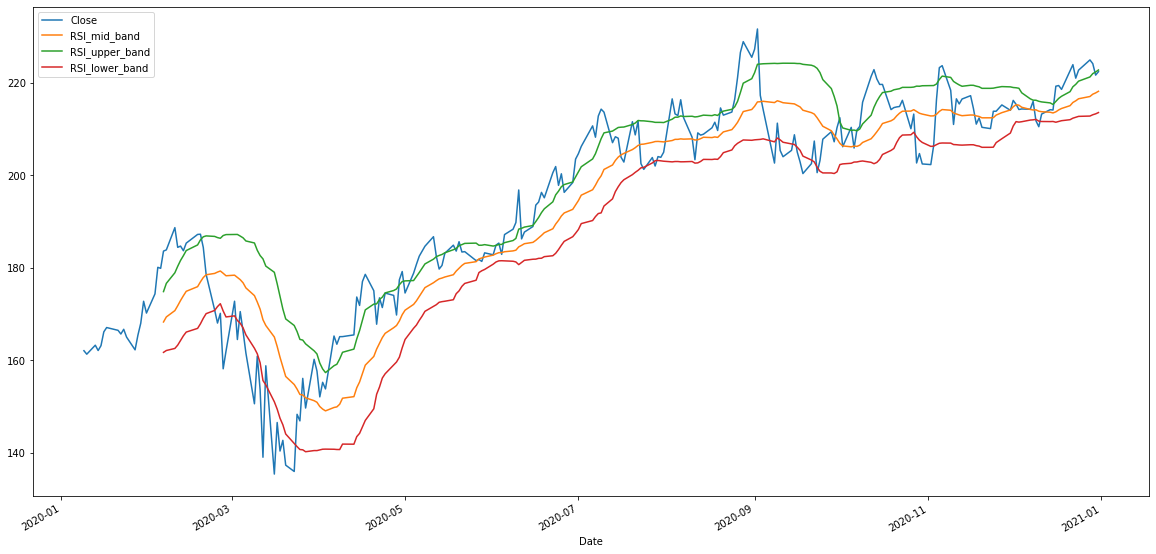

In [173]:
# Plot the RSI for closing prices
RSI_df[['Close','RSI_mid_band','RSI_upper_band','RSI_lower_band']].plot(figsize=(20,10))

In [174]:
# Calculate the strategy returns and add them to the signals_df DataFrame
RSI_df['Strategy Returns'] = RSI_df['Actual Returns'] * RSI_df['RSI_signal'].shift()

# Calculate the points in time at which a position should be taken, 1 or -1
RSI_df['Entry/Exit'] = RSI_df['RSI_signal'].diff()

# # Visualize exit position relative to close price
RSI_df['exit'] = RSI_df[RSI_df['Entry/Exit'] == -1.0]['Close']
RSI_df['entry'] = RSI_df[RSI_df['Entry/Exit'] == 1.0]['Close']

# Review the DataFrame
display(RSI_df.head())
display(RSI_df.tail())

,Close,Actual Returns,Target,rsi_20,RSI_mid_band,RSI_std,RSI_upper_band,RSI_lower_band,RSI_long,RSI_short,RSI_signal,Strategy Returns,Entry/Exit,exit,entry
Date,,,,,,,,,,,,,,,
2020-01-09,162.089996,0.012493,1.0,89.715044,NaN,NaN,NaN,NaN,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN
2020-01-10,161.339996,-0.004627,0.0,84.473648,NaN,NaN,NaN,NaN,0.0,-1.0,-1.0,0.004627,0.0,NaN,NaN
2020-01-13,163.279999,0.012024,1.0,86.604520,NaN,NaN,NaN,NaN,0.0,-1.0,-1.0,-0.012024,0.0,NaN,NaN
2020-01-14,162.130005,-0.007043,0.0,79.773055,NaN,NaN,NaN,NaN,0.0,-1.0,-1.0,0.007043,0.0,NaN,NaN
2020-01-15,163.179993,0.006476,0.0,81.198440,NaN,NaN,NaN,NaN,0.0,-1.0,-1.0,-0.006476,0.0,NaN,NaN


,Close,Actual Returns,Target,rsi_20,RSI_mid_band,RSI_std,RSI_upper_band,RSI_lower_band,RSI_long,RSI_short,RSI_signal,Strategy Returns,Entry/Exit,exit,entry
Date,,,,,,,,,,,,,,,
2020-12-24,222.750000,0.007827,0.0,58.259551,216.564000,3.807338,220.371338,212.756662,0.0,-1.0,-1.0,-0.007827,0.0,NaN,NaN
2020-12-28,224.960007,0.009921,0.0,60.330829,217.050500,4.226485,221.276985,212.824016,0.0,-1.0,-1.0,-0.009921,0.0,NaN,NaN
2020-12-29,224.149994,-0.003601,0.0,59.197491,217.554500,4.447586,222.002086,213.106913,0.0,-1.0,-1.0,0.003601,0.0,NaN,NaN
2020-12-30,221.679993,-0.011019,-1.0,55.831004,217.827999,4.528015,222.356014,213.299984,0.0,-1.0,-1.0,0.011019,0.0,NaN,NaN
2020-12-31,222.419998,0.003338,0.0,56.609194,218.180499,4.600429,222.780928,213.580070,0.0,-1.0,-1.0,-0.003338,0.0,NaN,NaN


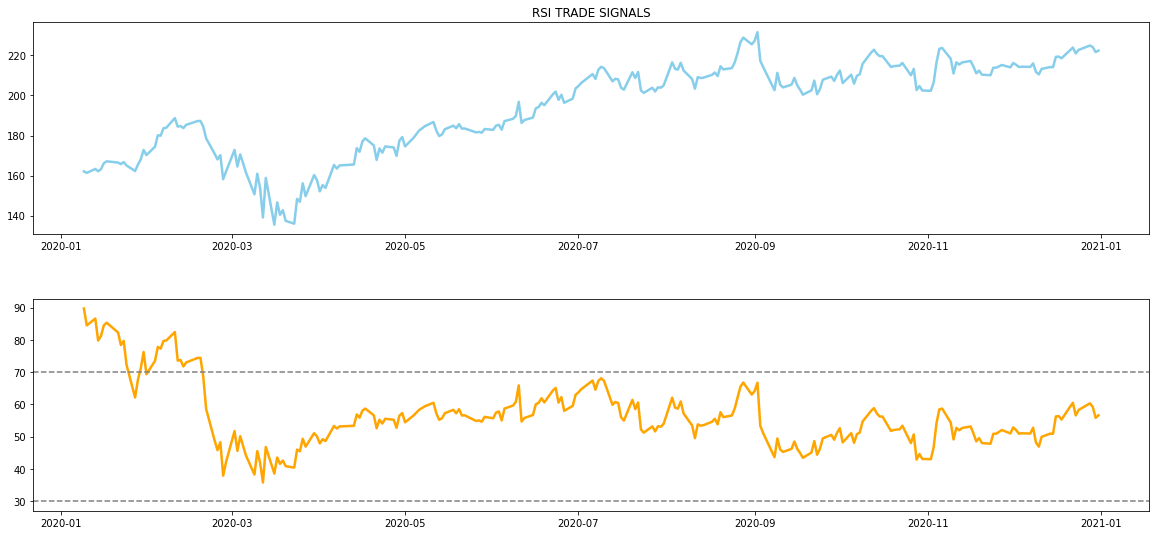

This trading signal has produced an average of 0.7497391087146755% alpha from 2020-01-09 00:00:00 to 2020-12-31 00:00:00


In [175]:
# Plot signal and buy/sell discipline
plt.figure(figsize=(20,10))
plt.xlabel('Date')
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(RSI_df['Close'], linewidth = 2.5, color = 'skyblue', label = 'RSI')
ax1.plot(RSI_df.index, RSI_df['entry'], marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(RSI_df.index, RSI_df['exit'], marker = 'v', markersize = 10, color = 'red', label = 'SELL SIGNAL')
ax1.set_title('RSI TRADE SIGNALS')
ax2.plot(RSI_df['rsi_20'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

alpha = ((1 + RSI_df['Strategy Returns']).cumprod().mean()) - ((RSI_df['Actual Returns']).cumprod().mean())
series_begin = RSI_df.index.min()
series_end = RSI_df.index.max()

print(f'This trading signal has produced an average of {alpha}% alpha from {series_begin} to {series_end}')


### Bollinger Bands

In [176]:
# Set bollinger band window
bollinger_window = 20

#create new df for bollinger bands
bb_df = signals_df.copy()

# Calculate rolling mean and standard deviation
bb_df['bollinger_mid_band'] = bb_df['Close'].rolling(window=bollinger_window).mean()
bb_df['bollinger_std'] = bb_df['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
bb_df['bollinger_upper_band']  = bb_df['bollinger_mid_band'] + (bb_df['bollinger_std'] * 1)
bb_df['bollinger_lower_band']  = bb_df['bollinger_mid_band'] - (bb_df['bollinger_std'] * 1)

# Calculate bollinger band trading signal
bb_df['bollinger_long'] = np.where(bb_df['Close'] < bb_df['bollinger_lower_band'], 1.0, 0.0)
bb_df['bollinger_short'] = np.where(bb_df['Close'] > bb_df['bollinger_upper_band'], -1.0, 0.0)
bb_df['bollinger_signal'] = bb_df['bollinger_long'] + bb_df['bollinger_short']


bb_df

,Close,Actual Returns,Target,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,
2020-01-03,158.619995,-0.012452,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2020-01-06,159.029999,0.002585,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2020-01-07,157.580002,-0.009118,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2020-01-08,160.089996,0.015928,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2020-01-09,162.089996,0.012493,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,222.750000,0.007827,0.0,216.564000,3.807338,220.371338,212.756662,0.0,-1.0,-1.0
2020-12-28,224.960007,0.009921,0.0,217.050500,4.226485,221.276985,212.824016,0.0,-1.0,-1.0
2020-12-29,224.149994,-0.003601,0.0,217.554500,4.447586,222.002086,213.106913,0.0,-1.0,-1.0


<AxesSubplot:xlabel='Date'>

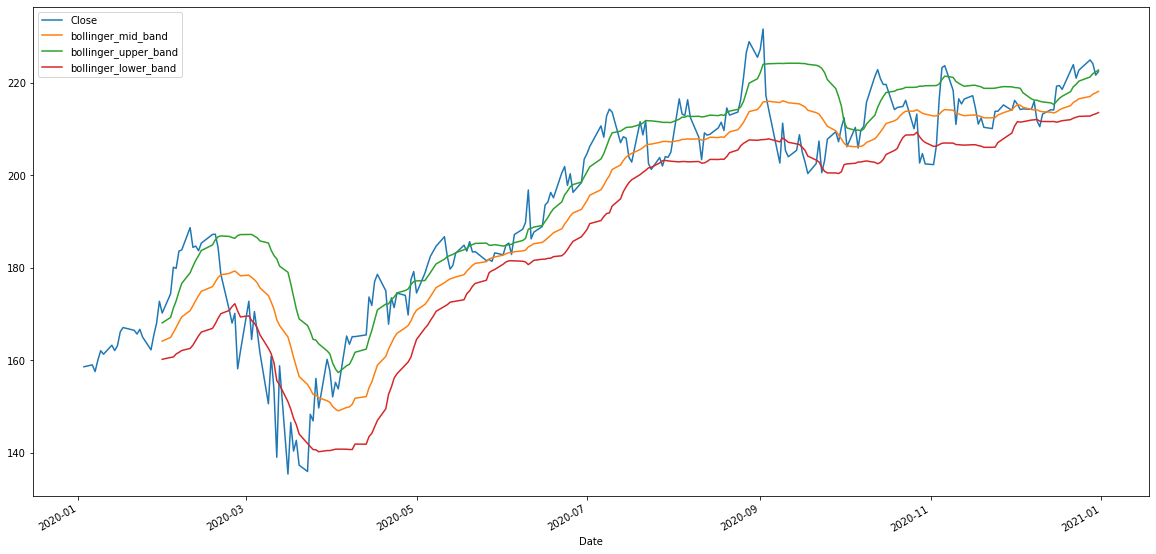

In [177]:
# Plot the Bollinger Bands for closing prices
bb_df[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [178]:
# Calculate the strategy returns and add them to the signals_df DataFrame
bb_df['Strategy Returns'] = bb_df['Actual Returns'] * bb_df['bollinger_signal'].shift()

# Calculate the points in time at which a position should be taken, 1 or -1
bb_df['Entry/Exit'] = RSI_df['RSI_signal'].diff()

# # Visualize exit position relative to close price
bb_df['exit'] = bb_df[bb_df['Entry/Exit'] == -1.0]['Close']
bb_df['entry'] = bb_df[bb_df['Entry/Exit'] == 1.0]['Close']


# Review the DataFrame
display(bb_df.head())
display(bb_df.tail())

,Close,Actual Returns,Target,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Strategy Returns,Entry/Exit,exit,entry
Date,,,,,,,,,,,,,,
2020-01-03,158.619995,-0.012452,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2020-01-06,159.029999,0.002585,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2020-01-07,157.580002,-0.009118,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-0.0,NaN,NaN,NaN
2020-01-08,160.089996,0.015928,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2020-01-09,162.089996,0.012493,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN


,Close,Actual Returns,Target,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Strategy Returns,Entry/Exit,exit,entry
Date,,,,,,,,,,,,,,
2020-12-24,222.750000,0.007827,0.0,216.564000,3.807338,220.371338,212.756662,0.0,-1.0,-1.0,-0.007827,0.0,NaN,NaN
2020-12-28,224.960007,0.009921,0.0,217.050500,4.226485,221.276985,212.824016,0.0,-1.0,-1.0,-0.009921,0.0,NaN,NaN
2020-12-29,224.149994,-0.003601,0.0,217.554500,4.447586,222.002086,213.106913,0.0,-1.0,-1.0,0.003601,0.0,NaN,NaN
2020-12-30,221.679993,-0.011019,-1.0,217.827999,4.528015,222.356014,213.299984,0.0,0.0,0.0,0.011019,0.0,NaN,NaN
2020-12-31,222.419998,0.003338,0.0,218.180499,4.600429,222.780928,213.580070,0.0,0.0,0.0,0.000000,0.0,NaN,NaN


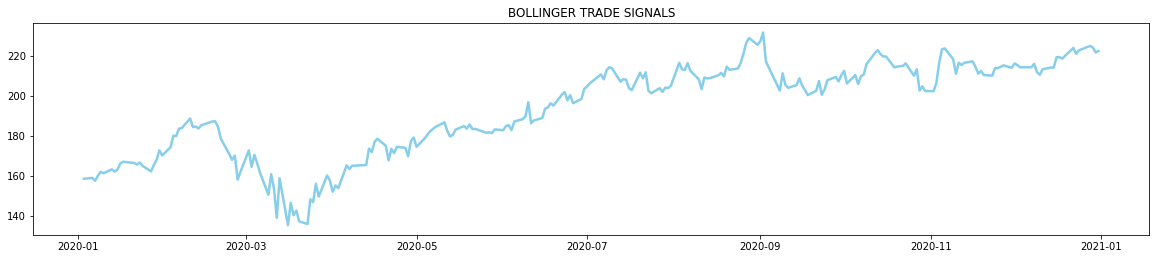

This trading signal has produced an average of 1.0729749599390448% alpha from 2020-01-03 00:00:00 to 2020-12-31 00:00:00


In [179]:
# Plot signal and buy/sell discipline
plt.figure(figsize=(20,10))
plt.xlabel('Date')
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax1.plot(bb_df['Close'], linewidth = 2.5, color = 'skyblue', label = 'RSI')
ax1.plot(bb_df.index, bb_df['entry'], marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(bb_df.index, bb_df['exit'], marker = 'v', markersize = 10, color = 'red', label = 'SELL SIGNAL')
ax1.set_title('BOLLINGER TRADE SIGNALS')
plt.show()


alpha = ((1 + bb_df['Strategy Returns']).cumprod().mean()) - ((bb_df['Actual Returns']).cumprod().mean())
series_begin = bb_df.index.min()
series_end = bb_df.index.max()
print(f'This trading signal has produced an average of {alpha}% alpha from {series_begin} to {series_end}')

## Consolidate Signals into one DF
---

In [188]:
master_df = signals_df.join(RSI_df, lsuffix='RSI', rsuffix='BB').join(bb_df, lsuffix='RSI', rsuffix='BB').join(val_signals_df, lsuffix='BB', rsuffix='SMA').join(trading_signals, lsuffix='RSI', rsuffix='MACD')

In [189]:
master_df.head()

,CloseRSI,Actual ReturnsRSI,TargetRSI,CloseBB,Actual ReturnsBB,TargetBB,rsi_20,RSI_mid_band,RSI_std,RSI_upper_band,...,SignalRSI,Entry/ExitRSI,Close,SMA50MACD,SMA100MACD,SignalMACD,Entry/ExitMACD,MACD,Entry_Point,Exit_Point
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,158.619995,-0.012452,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,158.619995,NaN,NaN,-0.029538,0.0,-0.147692,NaN,158.619995
2020-01-06,159.029999,0.002585,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,159.029999,NaN,NaN,-0.069745,0.0,-0.230570,NaN,NaN
2020-01-07,157.580002,-0.009118,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,157.580002,NaN,NaN,-0.135661,0.0,-0.399326,NaN,NaN
2020-01-08,160.089996,0.015928,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,160.089996,NaN,NaN,-0.176615,0.0,-0.340428,NaN,NaN
2020-01-09,162.089996,0.012493,1.0,162.089996,0.012493,1.0,89.715044,NaN,NaN,NaN,...,0.0,0.0,162.089996,NaN,NaN,-0.169831,0.0,-0.142696,162.089996,NaN


## Prepare the Machine Learning Models
---

### Split the data into training and testing datasets

In [182]:
# Assign Target column to a features DataFrame called X
X = bb_df[['Target']].shift().dropna()

# Review the DataFrame
X.tail()

,Target
Date,
2020-12-24,-1.0
2020-12-28,0.0
2020-12-29,0.0
2020-12-30,0.0
2020-12-31,-1.0


In [183]:
# Create the target set selecting the Signal column and assiging it to y
y = bb_df['bollinger_signal']

# Review the value counts
y.value_counts()

 0.0    127
-1.0     91
 1.0     34
Name: bollinger_signal, dtype: int64

In [184]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2020-01-06 00:00:00


In [185]:
# Select the ending period for the training data with an offset of 3 months
training_end = training_begin + DateOffset(months=216)

# Display the training end date
print(training_end)

2038-01-06 00:00:00


In [186]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,Target
Date,
2020-01-06,-1.0
2020-01-07,0.0
2020-01-08,0.0
2020-01-09,1.0
2020-01-10,1.0


In [187]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

,Target
Date,
